In [55]:
%matplotlib inline

# Usual datascience libs below
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import random
import patsy

# Import custom libs below
import models

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Helper functions
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
def rmse( y, y_hat):
    return np.sqrt((1.0/len( y)) * np.sum((y - y_hat)**2))

# Module 13 Lab - Rule Based Machine Learning - Example

## Directions

1. Show all work/steps/calculations. Generate a Markdown/code cells for each answer.
2. You must submit your lab by the deadline to the Lab section of the Course Module where you downloaded this file from.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

**Pre-Processing**

In [2]:
# Import LabelEncoder
from sklearn import preprocessing

# Creating labelEncoder
le = preprocessing.LabelEncoder()

# Import insurance dataset
df = pd.read_csv( "insurance.csv")

# Drop Duplicates
df = df.drop_duplicates()

# Reset Index since we removed duplicates
df = df.reset_index(drop=True)

# Convert string class to numerical
for i in range(0, df.shape[1]):
    if df.dtypes[i]=='object':
        df[df.columns[i]] = le.fit_transform(df[df.columns[i]])
        
# Add "BMI Above 30 feature"
df["bmi_above_30"] = df.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

df['age_sq'] = df['age'] * 2.2

# Verify steps are done correctly
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_above_30,age_sq
0,19,0,27.900,0,1,3,16884.92400,0,41.8
1,18,1,33.770,1,0,2,1725.55230,1,39.6
2,28,1,33.000,3,0,2,4449.46200,1,61.6
3,33,1,22.705,0,0,1,21984.47061,0,72.6
4,32,1,28.880,0,0,1,3866.85520,0,70.4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 9 columns):
age             1337 non-null int64
sex             1337 non-null int64
bmi             1337 non-null float64
children        1337 non-null int64
smoker          1337 non-null int64
region          1337 non-null int64
charges         1337 non-null float64
bmi_above_30    1337 non-null int64
age_sq          1337 non-null float64
dtypes: float64(3), int64(6)
memory usage: 94.1 KB


We talked about a wide variety of algorithms this module but we're going to concentrate on just two: Decision Trees and Random Forests.

> The requested linear regression comparison was omitted so I'm including it here. We need the actual results to calculate an estimate of the difference of means ("test") later.

In [37]:
model = "charges ~ age_sq + sex + bmi + smoker + smoker:bmi + smoker:bmi_above_30 + children + sex:children"
lr_result = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(lr_result)

In [51]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Here are the cross validation results for this linear regression model:

In [56]:
formula = "charges ~ age_sq + sex + bmi + smoker + smoker:bmi + smoker:bmi_above_30 + children + sex:children"
lr_result = cross_validation(models.linear_regression, formula, df, lambda r: (r["sigma"], r["r_squared"]))

**Problem 1.**

Using the insurance data set, construct a Decision Tree to estimate charges using the Scikit Learn Library [Decision Tree](https://scikit-learn.org/stable/modules/tree.html). You should use validation curves to estimate the best tree depth. With this tree depth, perform 3 rounds of 10 fold cross validation to get a sense of generalization error and learning curves to estimate bias/variance trade-off.

Visualize the tree if possible. 

Compare with your linear regression results. Use Bayesian inference to test the difference of means.

In [4]:
seed = 101
set_seed(seed)

# Import train_test_split function
from sklearn.model_selection import train_test_split

features = ['age', 'smoker', 'bmi_above_30', 'sex', 'children', 'region']

# Train, test, split the data
X = df[features] # Features
y = df['charges'] # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed) # 70% training and 30% test

# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=seed)

#Train the model using the training sets 
regressor.fit(X_train,y_train)
y_true = np.array(y_test)
y_pred = regressor.predict(X_test)

# Print Evaluation Metrics
print('Decision Tree Regressor,  R^2: %f' % regressor.score(X_test, y_test))
print('Decision Tree Regressor, RMSE: %f' % rmse(y_true, y_pred))
from sklearn.metrics import r2_score,mean_squared_error
print(r2_score(y_true, y_pred))
print(np.sqrt(mean_squared_error(y_true, y_pred)))

Decision Tree Regressor,  R^2: 0.723599
Decision Tree Regressor, RMSE: 6223.656541
0.7235989956308251
6223.656540709659


If we recall previous linear regression model, below are the metrics we got:

Linear Regression RMSE: 4404.579005
Linear Regression $R^2$: 0.87

The current Decision Tree Regression without figuring out the best tree depth is actually doing worse than Linear Regression Model, so now let's find out the best tree depth with validation curve.

In [5]:
def validation_curve(seed, X, y, min_depth, max_depth, test_size=0.30):
    train_scores = []
    test_scores = []
    
    for i in range(min_depth, max_depth + 1):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        
        reg = DecisionTreeRegressor(random_state=seed, max_depth=i)
        
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        train_scores.append(rmse(y_train, y_pred))
        
        y_pred = reg.predict(X_test)
        test_scores.append(rmse(y_test, y_pred))
        
    return train_scores, test_scores

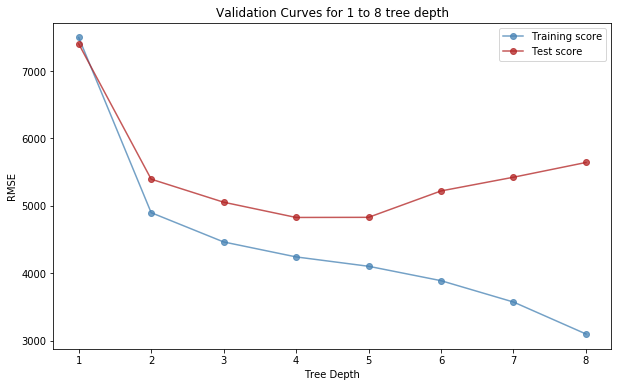

In [6]:
seed = 101
min_depth = 1
max_depth = 8
param_range = range(min_depth, max_depth + 1)
x_label = 'Tree Depth'
y_label = 'RMSE'
title = "Validation Curves for {0} to {1} tree depth".format(min_depth, max_depth)

train_scores, test_scores = validation_curve(seed, X, y, min_depth, max_depth)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

It looks like tree depth of 4 is the sweet spot for best bias/variance trade off, as we increase tree depth we tend to overfit the model.

In [7]:
# Set Seed first
seed = 101

# Perform 10 fold CV
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10, random_state=seed)

#Train the model using the training sets 
regressor = DecisionTreeRegressor(random_state=seed, max_depth=4)
regressor.fit(X_train,y_train)
results = model_selection.cross_val_score(regressor, X, y, cv=kfold)
print(results.mean())

0.8541995009265271


The CV mean results are pretty good.

> I asked for 3 rounds of 10 fold cross validation which I am adding here:

## Bayesian Inference

In [41]:
dt_results = []
for i in range(0, 3):
    kfold = model_selection.KFold(n_splits=10, random_state=seed)

    #Train the model using the training sets 
    regressor = DecisionTreeRegressor(random_state=seed, max_depth=4)
    regressor.fit(X_train,y_train)
    results = model_selection.cross_val_score(regressor, X, y, cv=kfold)
    dt_results = np.concatenate((dt_results, results), axis=None)

The mean results are:

In [43]:
np.mean(dt_results)

0.8541995009265271

Now we can use the bootstrap to estimate the difference of means for the two models:

In [44]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [57]:
lr_bootstrap = bootstrap_sample([r[1] for r in lr_result], np.mean)
dt_bootstrap = bootstrap_sample(dt_results, np.mean)
difference = dt_bootstrap - lr_bootstrap

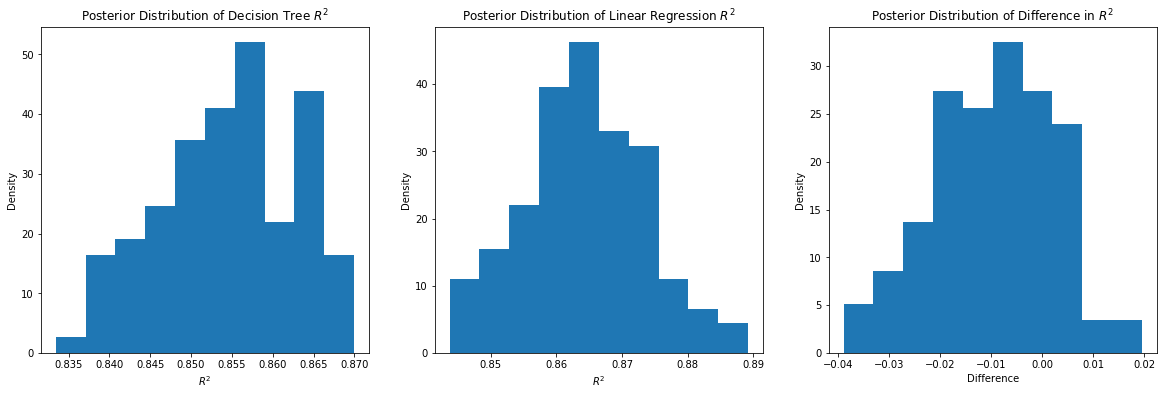

In [58]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(dt_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Decision Tree $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Linear Regression $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.show()
plt.close()

It looks like the Decision Tree is a bit worse, what is the probability that it's mean $R^2$ is better than the mean $R^2$ for the linear regression?

In [60]:
print("P(DT > LR)", np.mean(difference >= 0))
print("P(LR > DT)", np.mean(difference < 0))

P(DT > LR) 0.24
P(LR > DT) 0.76


There's only a 24% probability, based on the evidence, that the Decision Tree is a better model (with the current features).

## Learning Curves

What should we do to make the Decision Tree better?

In [8]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    from sklearn.model_selection import learning_curve
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.25,
                     color="steelblue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.25, color="firebrick")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="firebrick",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    plt.close()

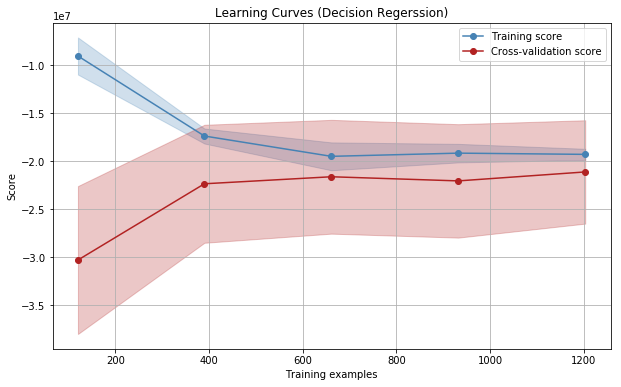

In [9]:
seed = 101
title = "Learning Curves (Decision Regression)"
estimator = DecisionTreeRegressor(random_state=seed, max_depth=4)
plot_learning_curve(estimator, title, X, y, cv=10, n_jobs=1)

As we discussed in previous labs, increasing training samples doesn't help improve the model, which is clearly seen here in this case.

> The scale here is in 1e7! Always look at the scale or you can be deceived.

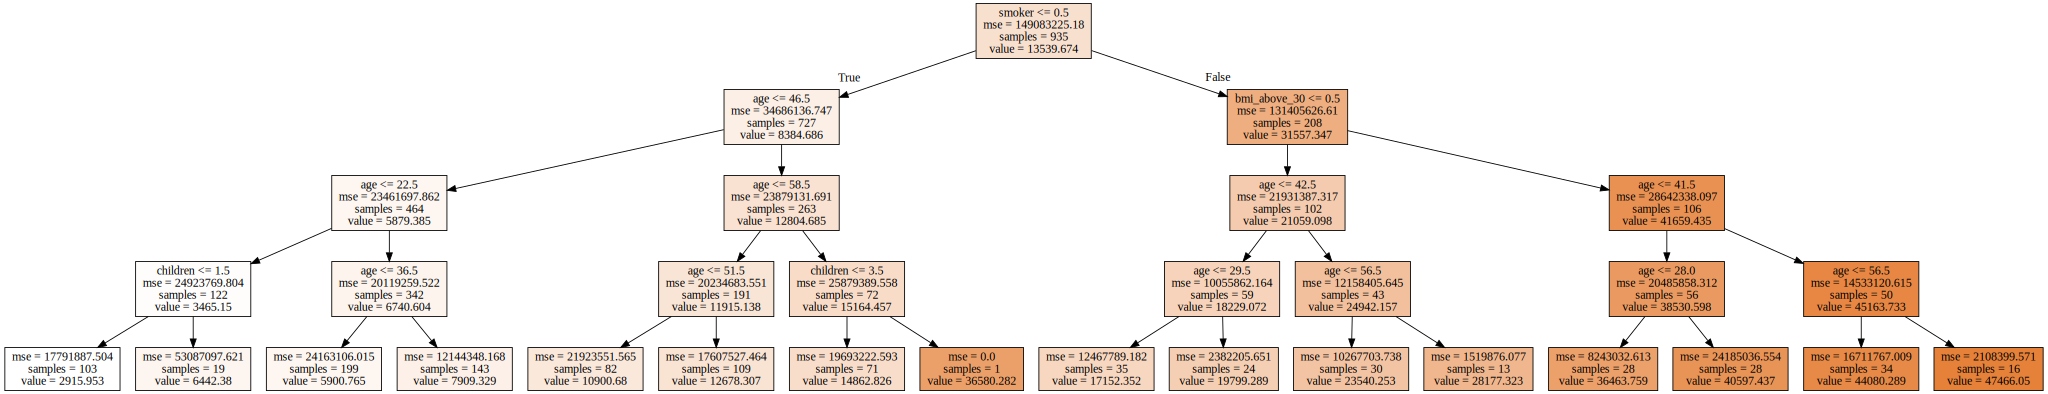

In [10]:
from sklearn import tree
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

features = ['age', 'smoker', 'bmi_above_30', 'sex', 'children', 'region']
regressor = DecisionTreeRegressor(random_state=seed, max_depth=4)
regressor.fit(X_train,y_train)
graph = Source(tree.export_graphviz(regressor, out_file=None, filled = True, feature_names=features))
display(SVG(graph.pipe(format='svg')))

** Problem 2.**

Now use the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) on the insurance data set. Use validation curves to optimize the hyperparameters. Estimate generalization error on 3 rounds of 10 fold cross validation. Instead of learning curves, examine the importance of the features. How does this compare with your linear regression from before?

In [11]:
seed = 101
set_seed(seed)

features = ['age', 'smoker', 'bmi_above_30', 'sex', 'children', 'region']

# Train, test, split the data
X = df[features] # Features
y = df['charges'] # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(random_state=seed)

#Train the model using the training sets 
rfc.fit(X_train,y_train)
y_true = np.array(y_test)
y_pred = rfc.predict(X_test)

# Print Evaluation Metrics
print('Decision Tree Regressor,  R^2: %f' % rfc.score(X_test, y_test))
print('Decision Tree Regressor, RMSE: %f' % rmse(y_true, y_pred))

Decision Tree Regressor,  R^2: 0.802658
Decision Tree Regressor, RMSE: 5258.792263


In [12]:
def validation_curve(seed, X, y, min_val, max_val, step, test_size=0.30):
    train_scores = []
    test_scores = []
    
    for i in range(min_val, max_val + 10):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        reg = RandomForestRegressor(random_state=seed, n_estimators=i)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        train_scores.append(rmse(y_train, y_pred))
        y_pred = reg.predict(X_test)
        test_scores.append(rmse(y_test, y_pred))
    return train_scores, test_scores

seed = 101
min_val = 10
max_val = 100
step = 10
param_range = range(min_val, max_val + step)
x_label = 'No. of Trees in RandomForest'
y_label = 'RMSE'
title = "Validation Curves for {0} to {1} trees in forest".format(min_val, max_val)

train_scores, test_scores = validation_curve(seed, X, y, min_val, max_val, step=200)

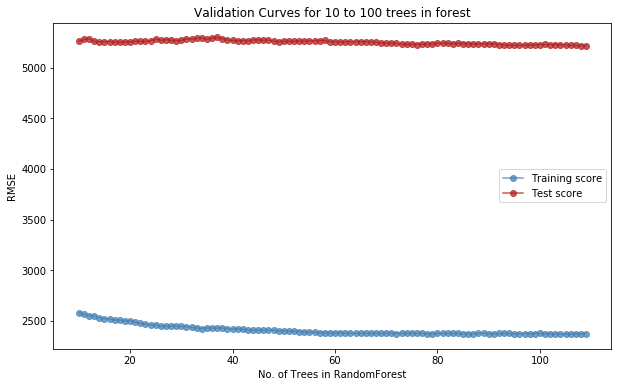

In [13]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

There is no difference when it comes to increasing number of trees in random forest, so tuning this hyperparameter won't help.

> This was missing from the submission.

## Feature Importance

Let's look at the feature importance:

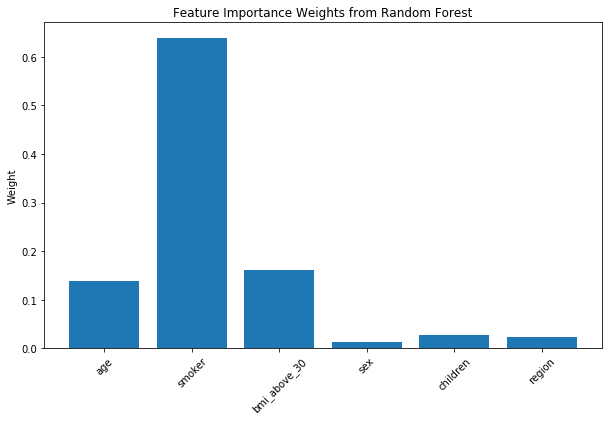

In [31]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)



axes.bar(list(range(0, len(features))), rfc.feature_importances_)
axes.set_xticks(np.arange(len(features)))
axes.set_xticklabels(features, rotation = 45)

axes.set_ylabel("Weight")
axes.set_title("Feature Importance Weights from Random Forest")

plt.show()
plt.close()

Although the importance is similar to what we saw for regression


> Remember what classification/regression is. We have observations (X, y). We believe there is a relationship f(X) and we want to learn it but we have no idea of knowing what shape f(X) has. We use an algorithm G(X, y) to learn an approximation of f(X), which we call F(X). G(X,  y) is a *specific* algorithm so it might be CART or C4.5 or it could be Ordinary Least Squares or Stochastic Gradient Descent. The result is a model F(X) we can use to make estimates/predictions. F(X) has a representation bias. f(X) is probably *not* "really" a decision tree but it can be approximated by a decision tree or perhaps a linear model approximates it better.

> Because of the representation bias, the features determined to be important by a, say, Random Forest may not be the same features identified to be important by a Linear Regression (and confidence intervals).